# Find Points

## Load csv files

In [1]:
import pandas as pd
import numpy as np

file_info_df = pd.read_csv('../../dataset/EchoNet/FileInfo.csv')
train_df = file_info_df[file_info_df['Split'] == 'Train']
train_df.head()

,FileName,Split,ESV,EDV
0,0X650881B7ADEF9668,Train,157,179
1,0X23B1641319A2AFA2,Train,50,66
2,0X21780197024E9D79,Train,61,76
3,0X304FEB38430F6379,Train,46,63
4,0X7FE48E5475ADE2E3,Train,119,94


In [2]:
tracing_df = pd.read_csv('../../dataset/EchoNet/VolumeTracings.csv')
tracing_df.head()

,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.125000,46
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.321330,46
2,0X100009310A3BD7FC.avi,49.157378,20.407629,57.090549,18.390722,46
3,0X100009310A3BD7FC.avi,48.538173,23.581055,59.997339,20.667707,46
4,0X100009310A3BD7FC.avi,47.918968,26.754480,62.904129,22.944693,46


## Find all points at once

In [3]:
import pandas as pd
import numpy as np
import cv2

def find_vertical_points(points):
    y_diff = 0
    points_top = (0, 0)
    points_bottom = (0, 0)
    for _, data in points.iterrows():
        x1, y1, x2, y2 = data['X1'], data['Y1'], data['X2'], data['Y2']
        temp_y_diff = abs(y1 - y2)
        if temp_y_diff > y_diff:
            y_diff = temp_y_diff
            if y1 < y2:
                points_top = (min(int(x1+0.5), 111), min(int(y1+0.5), 111))
                points_bottom = (min(int(x2+0.5), 111), min(int(y2+0.5), 111))
            else:
                points_top = (min(int(x2+0.5), 111), min(int(y2+0.5), 111))
                points_bottom = (min(int(x1+0.5), 111), min(int(y1+0.5), 111))
    return points_top, points_bottom

def split_points(points):
    points_left = list()
    points_right = list()
    for _, data in points.iterrows():
        x1, y1, x2, y2 = data['X1'], data['Y1'], data['X2'], data['Y2']
        if x1 < x2:
            points_left.append((x1, y1))
            points_right.append((x2, y2))
        else:
            points_left.append((x2, y2))
            points_right.append((x1, y1))
    points_left.sort(key=lambda x: x[1])
    points_right.sort(key=lambda x: x[1])
    return points_left, points_right

def define_starting_point(base_point, box_position, box_size):
    x, y = int(base_point[0]+0.5), int(base_point[1]+0.5)
    if box_position == 'upper_left':
        start_col, start_row = x - box_size[1], y - box_size[0]
    elif box_position == 'central_left':
        start_col, start_row = x - box_size[1], y - box_size[0] // 2
    elif box_position == 'lower_left':
        start_col, start_row = x - box_size[1], y
    elif box_position == 'upper_right':
        start_col, start_row = x, y - box_size[0]
    elif box_position == 'central_right':
        start_col, start_row = x, y - box_size[0] // 2
    elif box_position == 'lower_right':
        start_col, start_row = x, y
    else:
        start_col, start_row = x - box_size[1] // 2, y - box_size[0] // 2
    return (start_col, start_row)
        
def find_brightest_point_in_box(base_point, box_position, box_size, img):
    start_col, start_row = define_starting_point(base_point, box_position, box_size)
    end_col, end_row = min(start_col + box_size[1], 112), min(start_row + box_size[0], 112)
    brightest_point = (0, 0)
    brightest_value = 0
    for c in range(start_col, end_col):
        for r in range(start_row, end_row):
            if img[r, c] > brightest_value:
                brightest_value = img[r, c]
                brightest_point = (c, r)
    return brightest_point

def find_outermost_bottom_point(points, n, out_direction, sorted_y=True):
    if not sorted_y:
        points.sort(key=lambda x: x[1])
    points = points[-n:]
    points.sort(key=lambda x: x[0])
    if out_direction == 'left' or out_direction == 'l':
        return points[0]
    elif out_direction == 'right' or out_direction == 'r':
        return points[-1]
    return points[len(points) // 2]

def find_darkest_point_in_box(base_point, box_position, box_size, img):
    start_col, start_row = define_starting_point(base_point, box_position, box_size)
    end_col, end_row = min(start_col + box_size[1], 112), min(start_row + box_size[0], 112)
    darkest_point = (0, 0)
    darkest_value = 255
    for c in range(start_col, end_col):
        for r in range(start_row, end_row):
            if img[r, c] < darkest_value:
                darkest_value = img[r, c]
                darkest_point = (c, r)
    return darkest_point

def find_outermost_dark_point(base_point, box_position, box_size, out_direction, img):
    start_col, start_row = define_starting_point(base_point, box_position, box_size)
    end_col, end_row = min(start_col + box_size[1], 112), min(start_row + box_size[0], 112)
    dark_points = list()
    threshold = img.max() * 0.3
    for c in range(start_col, end_col):
        for r in range(start_row, end_row):
            if img[r, c] < threshold:
                dark_points.append((c, r))
    dark_points.sort(key=lambda x: x[0])
    if out_direction == 'left' or out_direction == 'l':
        return dark_points[0]
    elif out_direction == 'right' or out_direction == 'r':
        return dark_points[-1]
    return base_point

def find_center_point(left_point, right_point):
    return (int((left_point[0] + right_point[0]) // 2), int((left_point[1] + right_point[1]) // 2))

In [4]:
from tqdm import tqdm

points_df = pd.DataFrame()

pbar = tqdm(train_df['FileName'], total=len(train_df['FileName']), desc='Find points', ascii=" =", leave=True)

for name in pbar:
    video_format = '.avi'
    esv_frame = train_df[train_df['FileName'] == name]['ESV'].values[0]
    # ESV frame에서 좌표들 가져오기
    points = tracing_df[tracing_df['FileName'] == f'{name}{video_format}']
    points = points[points['Frame'] == esv_frame]
    # 좌표 중 세로 축 두 좌표 찾기   위 좌표 -> positive, 아래 좌표 -> negative
    points_top, points_bottom = find_vertical_points(points)
    # 좌, 우 좌표 나누기
    points_left, points_right = split_points(points)
    # 좌, 우 중앙 좌표 찾기
    center_left = points_left[len(points_left) // 2]
    center_right = points_right[len(points_right) // 2]
    # 이미지 불러오기
    img_path = f'../../dataset/EchoNet/Images/{name}/{esv_frame}.jpg'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    box_size = (13, 13)
    # negative 좌,우 좌표 찾기
    n_left_x, n_left_y = find_brightest_point_in_box(center_left, 'central_left', box_size, img)
    n_right_x, n_right_y = find_brightest_point_in_box(center_right, 'central_right', box_size, img)
    # positive 좌, 우, 중앙 좌표 찾기
    # 가장 어두운 부분 or threshold 이하의 값 중 가장 바깥 값 찾기
    bottom_left = find_outermost_bottom_point(points_left, 5, 'left')
    bottom_right = find_outermost_bottom_point(points_right, 5, 'right')
    # p_left_x, p_left_y = find_darkest_point_in_box(bottom_left, 'central_right', box_size, img)
    # p_right_x, p_right_y = find_darkest_point_in_box(bottom_right, 'central_left', box_size, img)
    p_left_x, p_left_y = find_outermost_dark_point(bottom_left, 'central_right', box_size, 'left', img)
    p_right_x, p_right_y = find_outermost_dark_point(bottom_right, 'central_left', box_size, 'right', img)
    p_center_x, p_center_y = find_center_point(center_left, center_right)
    # 데이터프레임에 추가
    temp_df = pd.DataFrame({
        'FileName': name,
        'PositiveTopX': points_top[0], 'PositiveTopY': points_top[1],
        'PositiveCenterX': p_center_x, 'PositiveCenterY': p_center_y,
        'PositiveLeftX': p_left_x, 'PositiveLeftY': p_left_y,
        'PositiveRightX': p_right_x, 'PositiveRightY': p_right_y,
        'NegativeBottomX': points_bottom[0], 'NegativeBottomY': points_bottom[1],
        'NegativeLeftX': n_left_x, 'NegativeLeftY': n_left_y,
        'NegativeRightX': n_right_x, 'NegativeRightY': n_right_y
    }, index=[0])
    points_df = pd.concat([points_df, temp_df], ignore_index=True)
points_df.head()
    

Find points: 100%|==========| 6018/6018 [02:39<00:00, 37.62it/s]


,FileName,PositiveTopX,PositiveTopY,PositiveCenterX,PositiveCenterY,PositiveLeftX,PositiveLeftY,PositiveRightX,PositiveRightY,NegativeBottomX,NegativeBottomY,NegativeLeftX,NegativeLeftY,NegativeRightX,NegativeRightY
0,0X650881B7ADEF9668,48,25,64,47,53,70,78,66,66,75,46,50,82,38
1,0X23B1641319A2AFA2,45,31,57,58,49,74,78,81,67,86,40,64,74,52
2,0X21780197024E9D79,48,15,58,46,42,64,80,73,62,77,37,45,83,51
3,0X304FEB38430F6379,50,18,54,43,45,54,66,65,57,68,40,42,74,38
4,0X7FE48E5475ADE2E3,49,18,61,45,50,63,88,68,73,69,41,59,86,34


# Cheack points

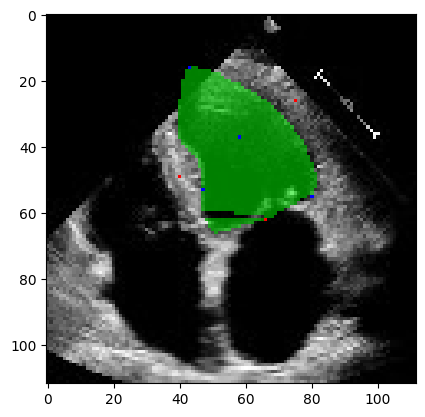

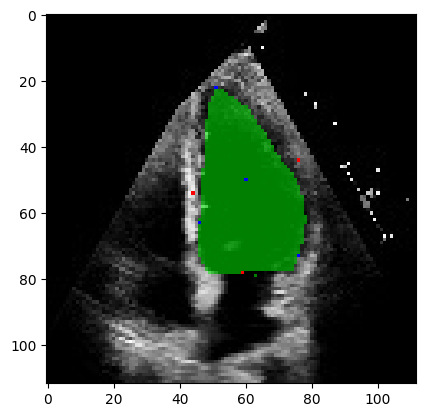

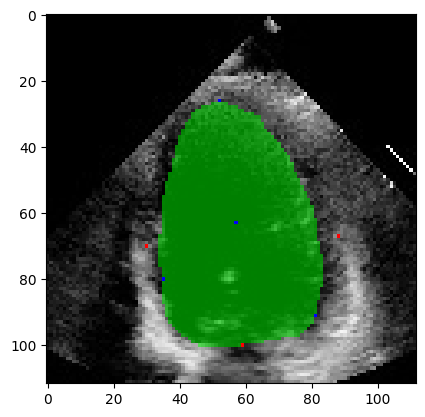

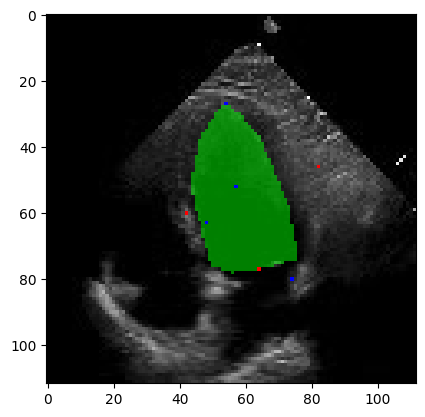

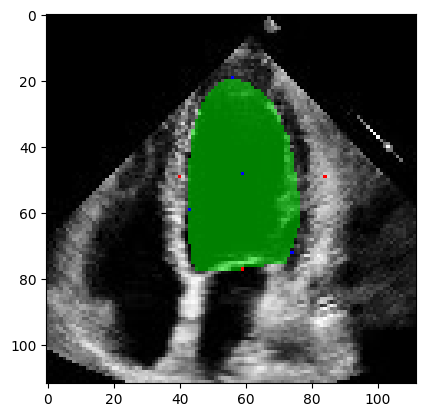

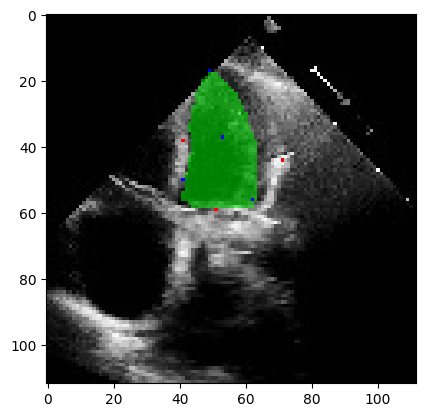

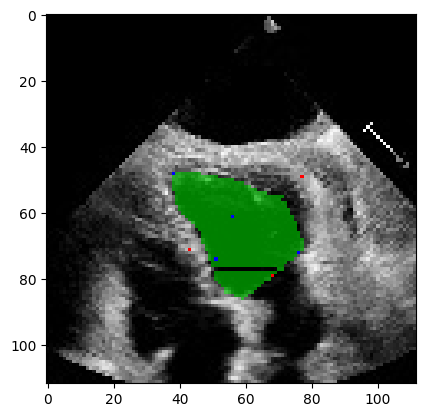

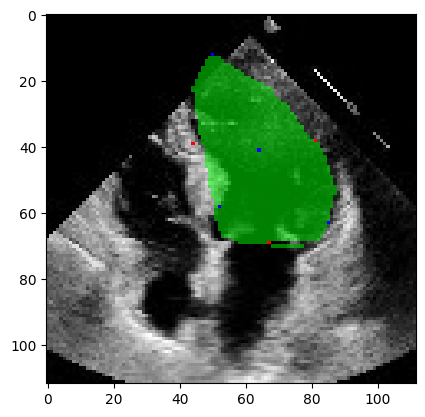

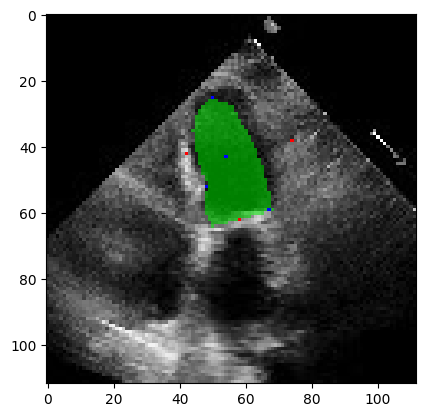

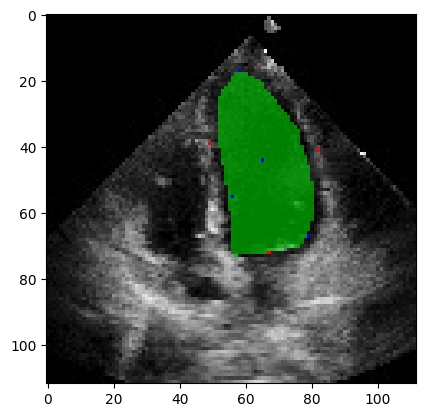

In [5]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

tracings_df = pd.read_csv('../../dataset/EchoNet/VolumeTracings.csv')

def cycling_points(name):
    tracings = tracings_df[tracings_df['FileName'] == name]
    frames = tracings['Frame'].unique()
    for f in frames:
        t = tracings[tracings['Frame'] == f]
        points_l = list()
        points_r = list()
        for i in range(len(t)):
            c_1 = min(int(t.iloc[i]['X1'] + 0.5), 111)
            r_1 = min(int(t.iloc[i]['Y1'] + 0.5), 111)
            c_2 = min(int(t.iloc[i]['X2'] + 0.5), 111)
            r_2 = min(int(t.iloc[i]['Y2'] + 0.5), 111)
            if c_1 > c_2:
                c_1, c_2 = c_2, c_1
                r_1, r_2 = r_2, r_1
            points_l.append((c_1, r_1))
            points_r.append((c_2, r_2))
        points_l.sort(key=lambda x: x[1])
        points_r.sort(key=lambda x: x[1], reverse=True)
        points = points_l + points_r
        return points


for i in range(10):
    name = np.random.choice(train_df['FileName'])
    esv_frame = train_df[train_df['FileName'] == name]['ESV'].values[0]
    img_path = f'../../dataset/EchoNet/Images/{name}/{esv_frame}.jpg'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    poly_img = Image.new('RGBA', img.shape, (0,0,0,0))
    draw = ImageDraw.Draw(poly_img)
    polygon_coords = cycling_points(f'{name}.avi')
    polygon_coords
    draw.polygon(polygon_coords, fill=(0, 255, 0, 128))

    all_points = points_df[points_df['FileName'] == name]
    positive_points = [(min((int(all_points['PositiveTopX'].values[0]+0.5)), 111), min(int(all_points['PositiveTopY'].values[0]+0.5), 111)), 
                    (all_points['PositiveCenterX'].values[0], all_points['PositiveCenterY'].values[0]), 
                    (all_points['PositiveLeftX'].values[0], all_points['PositiveLeftY'].values[0]), 
                    (all_points['PositiveRightX'].values[0], all_points['PositiveRightY'].values[0])]
    negative_points = [(min(int(all_points['NegativeBottomX'].values[0]+0.5), 111), min(int(all_points['NegativeBottomY'].values[0]+0.5), 111)), 
                    (all_points['NegativeLeftX'].values[0], all_points['NegativeLeftY'].values[0]), 
                    (all_points['NegativeRightX'].values[0], all_points['NegativeRightY'].values[0])]
    draw.point(positive_points, fill=(0, 0, 255))
    draw.point(negative_points, fill=(255, 0, 0))
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.imshow(poly_img)
    plt.show()

## Save point to csv file

In [7]:
points_df.to_csv('../../dataset/EchoNet/Points.csv', index=False)